# Sentiment Analysis with Bag of Words
#### Author: August Garibay

## Introduction
For this project, we will be analyzing the *sentiment labelled sentances* data set from the UCI. This source is actually three data collections from the respective sources: Amazon, IMDB, and Yelp. Each set is balanced and advertised to have been selected to have clear sentiment, so as to simplify the analysis. The data is labeled to have either a positive or negative sentiment. The samples themselves are short snippets taken from consumers on these websites. In order to make use of these samples, they will need to be processed into a form that is conducive to our classifier methods. To accomplish this, each sample will be vectorized by a process called *Bag of Words*

The Bag of Words approach is a simplistic NLP approach that discards contextual information from the analysis by simply treating the entry as a collection of words in no particular order. The frequency of a words occurence can be (and for us will be) used to weight the enumerations. If our bag has a finite collection of slots for words or words of a certain type, then we can place their quantifications into a vector and use these in a natural way with our familiar classifiers, such as SVM and nearest neighbors.

## The Data

Let's begin by setting up a viable vectorizer. This requires some forethought.
There are a few considerations in implementing the bag of words.
First, we need to consider if we would like to build up the feature lexicon from a quick scan of all of the data from all potential sources, from a similar scan of one type of source collection, or only from the training data.
All of these potentially have difficult to predict effects on the over/under fitting of our classifiers.
To handle this, our vectorizer will be built to be versatile enough to handle any of these cases.

The second consideration for our vectorizer is the number of features that comes from the bag of words method is substantial. Large vectors _with many 0's_ are not firendly to our machine learning goals. We will suffer terrible performance on the training end, but whatsmore, the noise may adversly affect the accuracy of our model. To deal with this, we will be employing a few tactics. 
* Case insensitive bagging
* Blacklisting common words
* Dimensional reduction with PCA

With this, we will try to build a suitible vectorizer

In [1]:
#We want to be able to sort these so the comparison operators are overloaded
class Word:

    def __init__(self, word, pos, freq):
        self.word = word
        self.pos = pos
        self.freq = freq
    
    def __str__(self):
        return self.word + " " + str(self.pos) + " " + str(self.freq)

    def __eq__(self, other):
        return self.freq == other.freq
    
    def __lt__(self, other):
        return self.freq < other.freq
    
    def __gt__(self, other):
        return self.freq > other.freq
    
    def __le__(self, other):
        return self.freq <= other.freq
    
    def __ge__(self, other):
        return self.freq >= other.freq
    
    def __ne__(self, other):
        return self.freq != other.freq
    
    def __add__(self, other):
        self.freq += other
        return self

class Lexicon:
    
    def __init__(self):
        self.lexicon = {}
        self.total_distinct_words = 0
        self.sorted_words = []
        self.needs_sorting = True
    
    def add(self, word):
        self.needs_sorting = True
        if str(word).isnumeric():
            return
        word = word.lower()
        if word in self.lexicon:
            self.lexicon[word] += 1
        else:
            new_word = Word(word, self.total_distinct_words, 1)
            self.lexicon[word] = new_word
            self.total_distinct_words += 1
    
    def getPos(self, word):
        return self.lexicon[word].pos

    def sort_if_needed(self):
        if self.needs_sorting:
            self.sorted_words = sorted(self.lexicon.values(), reverse=True)
            self.needs_sorting = False
    
    def getMostFrequent(self, n):
        self.sort_if_needed()
        return self.sorted_words[:n]
    
    def addFile(self, filename):
        with open(filename, 'r') as f:
            for line in f:
                for word in line.split():
                    self.add(word)
    



Below is a quick verification that the `Lexicon` class is working. Further it can give us an idea of what "Most common" blacklist will look like

Size of lexicon: 2489
['the 12 513', 'i 15 313', 'and 73 310', 'is 2 238', 'it 9 237', 'a 18 217', 'this 150 197', 'to 7 195', 'my 68 143', 'for 5 119', 'of 54 119', 'phone 178 118', 'not 106 115', 'with 152 107', 'very 79 102', 'was 78 90', 'in 10 87', 'on 139 87', 'that 130 75', 'have 36 72', 'good 20 66', 'great 24 63', 'you 45 62', 'as 103 45', 'but 145 45', 'works 125 43', 'had 173 43', 'so 0 42', 'are 60 41', 'battery 85 39', 'sound 75 35', 'one 58 34', 'has 114 34', 'all 143 34', 'quality 76 33', 'from 83 33', 'phone. 117 33', 'would 136 32', 'your 237 32', 'headset 262 32', 'it. 312 31', 'like 213 30', 'if 44 29', 'than 31 28', "i've 180 28", "don't 508 28", 'use 151 27', "it's 186 27", 'product 211 27', 'after 276 27', 'no 3 26', 'be 121 26', 'really 339 26', 'at 108 24', 'recommend 111 24', '- 349 24', 'or 48 23', 'does 293 23', 'work 450 23', 'get 38 22', 'when 81 22', 'only 265 22', "i'm 476 22", 'excellent 22 21', 'up 40 21', 'product. 253 21', 'just 305 21', 'any 112 20',

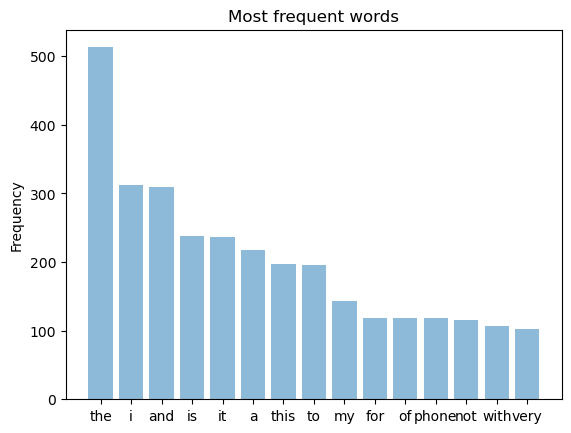

In [2]:
lexi = Lexicon()
lexi.addFile("data/amazon_cells_labelled.txt")
print("Size of lexicon: " + str(lexi.total_distinct_words))
print([str(x) for x in lexi.getMostFrequent(100)])

import matplotlib.pyplot as plt
import numpy as np

def plotMostFrequent(lexi, n):
    most_frequent = lexi.getMostFrequent(n)
    words = [x.word for x in most_frequent]
    freqs = [x.freq for x in most_frequent]
    y_pos = np.arange(len(words))
    plt.bar(y_pos, freqs, align='center', alpha=0.5)
    plt.xticks(y_pos, words)
    plt.ylabel('Frequency')
    plt.title('Most frequent words')
    plt.show()

plotMostFrequent(lexi, 15)

From this, it looks like the _most frequent_ blacklist is going to be very limited, as words like "good" come up very early but likely have a decision benefit in the analysis.

This lexicon we built can be built for any of the three files, or any combination of them.
This solves one of the above stated problems.
Still, we want to reduce the number of features.
To do this, we will build a smaller version of the lexicon that discriminates the words based on blacklists.
From this, we will build an object that we'll call a `Bag` which will map our words to our feature columns.
With this, building the vectorizer should be simple and versatile. 

One thing to account for here is that these initial vectorization schemes are what will be used with PCA, so in order to build PCA optimized vectorizers we'll want to be able to reinterpret the chosen columns as words again. So we will structure `Bag` so that it is easy to perform look-ups in both directions. This is not only useful for PCA analysis, but for limiting the lexicon to words found in the training data, as described in the begining of this section.

In [3]:
class Bag:

    def __init__(self, lexicon, blacklist=[], most_common_filter=0):
        self.lexicon = lexicon
        self.most_common = self.lexicon.getMostFrequent(most_common_filter)
        self.most_common_words = [x.word for x in self.most_common]
        self.blacklist = blacklist
        self.blacklist.extend(self.most_common_words)
        self.bag = [word.word for word in lexicon.lexicon.values() if word.word not in blacklist]
        self.size = len(self.bag)

    def __getitem__(self, arg):
        if str(arg).isnumeric():
            return self.bag[arg]
        if arg in self.bag:
            return self.bag.index(arg)
        return self.size 
    

Now as we build the actual vectorizer, there is another design feature that will prove useful.
The vectorizer will be equipped with a, `after_effect` property.
This is because the vectorizer will not only be used to build the training data, but we will also use it to vectorize test data.
If we apply techniques such as standardization or Inverse Document Frequency, we will need to apply the changes to the test data as well.

In [4]:
class BoW_Vectorizer:

    def __init__(self, bag):
        self.bag = bag
        self.after_effect = lambda x: x

    #extra column is used to catch words that are not in the bag
    def vectorize(self, text):
        vector = np.zeros(self.bag.size+1)
        for word in text.split():
            if word in self.bag:
                vector[self.bag[word]] += 1
        vector = vector[:self.bag.size]
        return self.after_effect(vector)

    def set_after_effect(self, after_effect):
        self.after_effect = after_effect

    def vectorize_data(self, filename):
        output_data = np.zeros((0, self.bag.size))
        output_labels = np.zeros((0, 1))
        data = pd.read_csv(filename, sep='\t', header=None)
        data.columns = ['text', 'label']
        for index, row in data.iterrows():
            output_data = np.append(output_data, [self.vectorize(row['text'])], axis=0)
            output_labels = np.append(output_labels, [[row['label']]], axis=0)
        output_labels = output_labels.reshape(output_labels.shape[0])
        return output_data, output_labels


In [5]:
#Now a simple test of the BoW_Vectorizer
lexi = Lexicon()
lexi.addFile("data/amazon_cells_labelled.txt")
bag = Bag(lexi, most_common_filter=1)
vectorizer = BoW_Vectorizer(bag)
test_vec = vectorizer.vectorize("This is a test of the vectorizer")
print("The phrase 'This is a test of the vectorizer' is vectorized as: ")
print(test_vec)
print("These are the columns with non-zero values")
print([i for i, x in enumerate(test_vec) if x != 0])
print("Here are those column titles from the bag")
print("bag[2] = " + bag[2])
print("bag[17] = " + bag[17])
print("bag[53] = " + bag[53])


# Full system test
import pandas as pd


output_data, output_labels = vectorizer.vectorize_data("data/amazon_cells_labelled.txt")
print("\nAnother test of the vectorizer. After vectorizing an entire 1000 entry file here is the shape of the data")
print(output_data.shape)

The phrase 'This is a test of the vectorizer' is vectorized as: 
[0. 0. 1. ... 0. 0. 0.]
These are the columns with non-zero values
[2, 17, 53]
Here are those column titles from the bag
bag[2] = is
bag[17] = a
bag[53] = of

Another test of the vectorizer. After vectorizing an entire 1000 entry file here is the shape of the data
(1000, 2488)


In the above test we can see the bag of words vectorization of the phrase "_This is a test of the vectorizer_ "
The most common word blacklist was used to remove only the most common word i.e. "*the*"
We can see that the words "This", "test", and "vectorizer" were not in the original lexicon at all.
The reverse `bag` look-up system yields the words that made it into the final vectorized representation.

The second test loaded the entire Amazon file. The size of the file verifies that all 1000 data entries were vectorized to a length 1 less than that of the lexicon.

## Preparing the experiments

Now that the data entries can be converted into usable data and that we have provided ourselves some flexibility in how we carry out this process, we can create a wrapper class for our classifiers that will help us control the experimental variables.
We will make a class called `BoW_Experiment` that will provide us with features such as PCA reduction, feature normalization, and Inverse Document Frequency.

`BoW_Experiment` will also provide us with a fully specified vectorizer instance for predicting on data external to the experiment set up.
`Bow_Experiment` will also perform dimensional reduction in the form of what we will refer to as `fog`. This is just removing any features that did not take a non-zero value in any of the training data.
The intuition behind the term `fog` is that it limits what the classifier is able to see.
Above this was regarded as an experimental variable, but will be included as a mandatory inclusion in `Bow_Experiment` since there should be no benefit to adding noise to the algorithm.

It will control the generate the data and the labels for the given experimental parameters. We may then utilize this sandboxed data for comparison testing over different `scikit-learn` classifiers on overall performance.  

In [6]:
"""
The contents of this cell were taken off of the internet.
I do not claim to have written this code.
All it does is suppress the warnings that scikitlearn throws when perceptrons are trained
These warnings made the notebook very messy and were not helpful
"""

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [7]:
from sklearn.decomposition import PCA

class BoW_Experiment:

    def __init__(self, classifier, pca_weight=1, IVD_weight=0, standard = False):
        self.classifier = classifier
        self.pca_weight = pca_weight
        self.IVD_weight = IVD_weight
        self.standard = standard
        self.effects = self._reckonEffects()

    def setBag(self, bag):
        self.bag = bag
        self.vectorizer = BoW_Vectorizer(bag)
        self.vectorizer.set_after_effect(self.effects)

    def fit(self, X, y):
        self.X = X.copy()
        self.y = y.copy()
        self.X = self.effects(self.X, training=True)
        self.classifier.fit(self.X, self.y)

    def predict_text(self, text):
        return self.classifier.predict(self.vectorizer.vectorize(text).reshape(1, -1))

    def predict(self, X):
        X_copy = X.copy()
        X_copy = self.effects(X_copy, training=False)
        return self.classifier.predict(X_copy)

    def score(self, X, y):
        X_copy = X.copy()
        X_copy = self.effects(X_copy, training=False)
        return self.classifier.score(X_copy, y)

    def get_vectorizer(self):
        return self.vectorizer

    def get_fog_columns(self):
        return self.fog_columns

    def get_components(self):
        return self.components

    def _reckonEffects(self):
        self._defaultEffects()
        if self.standard:
            self.standard_effect = self._standardize
        if self.pca_weight < 1:
            self.pca_effect = self._pca
        if self.IVD_weight > 0:
            self.IVD_effect = self._IVD
        self.fog_effect = self._fog
        def effects(data, training=False):
            data = self.fog_effect(data, training)
            data = self.IVD_effect(data, training)
            data = self.standard_effect(data, training)
            data = self.pca_effect(data, training)
            return data
        return effects

    def _defaultEffects(self):
        self.standard_effect = lambda x,t: x
        self.pca_effect = lambda x,t: x
        self.IVD_effect = lambda x,t: x
    
    def _dispatch_effect(self, effect, data, training):
        effects = {
            'standardize': {'vector': self._standardize, 'matrix': self._standardize_matrix},
            'pca': {'vector': self._pca_vector, 'matrix': self._pca_matrix},
            'IVD': {'vector': self._IVD_vector, 'matrix': self._IVD_matrix},
            'fog': {'vector': self._fog_vector, 'matrix': self._fog_matrix}
        }
        if data.ndim == 1:
            return effects[effect]['vector'](data)
        else:
            return effects[effect]['matrix'](data, training)

    def _standardize(self, target, training):
        return self._dispatch_effect('standardize', target, training)

    def _standardize_vector(self, target):
        target = target * self.standardization_factor + self.standardization_offset
        return target

    def _standardize_matrix(self, target, training):
        if training:
            self.standardization_factor = np.std(target, axis=0)
            self.standardization_offset = np.mean(target, axis=0)
        target = target * self.standardization_factor + self.standardization_offset
        return target

    def _pca(self, target, training):
        return self._dispatch_effect('pca', target, training)

    def _pca_vector(self, target):
        target = self.pca.transform(target.reshape(1, -1)).reshape(-1)
        return target

    def _pca_matrix(self, target, training):
        if training:
            n_components = int(self.pca_weight * target.shape[1])
            self.pca = PCA(n_components=n_components)
            self.pca.fit(target)
            self.components = self.pca.components_
        target = self.pca.transform(target)
        return target

    def _IVD(self, target, training):
        return self._dispatch_effect('IVD', target, training)

    def _IVD_vector(self, target):
        target = target  / self.IVD
        return target

    def _IVD_matrix(self, target, training):
        if training:
            self.IVD = np.sum(target, axis=0)
            self.IVD = self.IVD / target.shape[0]
        target = target / self.IVD
        return target

    def _fog(self, target, training):
        return self._dispatch_effect('fog', target, training)

    def _fog_vector(self, target):
        target = target[self.fog_columns]
        return target

    def _fog_matrix(self, target, training):
        if training:
            fog_columns = np.sum(target, axis=0)
            self.fog_columns = [i for i, x in enumerate(fog_columns) if x > 0]
        target = target[:, self.fog_columns]
        return target
        



This puts us in a position to perform the actual experiments.
We will establish sandbox parameters for the lexicons and the classifiers to facilitate this process

In [8]:
def buildLexicon(files):
    lexicon = Lexicon()
    for file in files:
        lexicon.addFile(file)
    return lexicon

lexicons = {
    'amazon': buildLexicon(['data/amazon_cells_labelled.txt']),
    'imdb': buildLexicon(['data/imdb_labelled.txt']),
    'yelp': buildLexicon(['data/yelp_labelled.txt']),
    'all': buildLexicon(['data/amazon_cells_labelled.txt', 'data/imdb_labelled.txt', 'data/yelp_labelled.txt'])
}

sources = {
    'amazon': 'data/amazon_cells_labelled.txt',
    'imdb': 'data/imdb_labelled.txt',
    'yelp': 'data/yelp_labelled.txt',
}

def getAllData():
    bag = Bag(lexicons['all'])
    vectorizer = BoW_Vectorizer(bag)
    X, y = vectorizer.vectorize_data(sources['amazon'])
    X2, y2 = vectorizer.vectorize_data(sources['imdb'])
    X3, y3 = vectorizer.vectorize_data(sources['yelp'])
    X = np.concatenate((X, X2, X3))
    y = np.concatenate((y, y2, y3))
    allData = (X, y)
    return allData

allData = getAllData()


## Preliminary Model Selection

In order to focus our experiments, we will run a few simple experiments to choose a shortlist of classifier types to use for further experimentation. For these we will use the combined corpus of all the datasets and no effects except for `fog`. We will select the optimal hyperparameters for a Perceptron, Nearest Neighbor, Linear SVM, Quadratic SVM, and Gaussian SVM. From the best performing, we will select our shortlist of classifiers and the hyperparameters that will accompany them for the remaining experiments.

Random guessing accuracy: 0.4727272727272727


Text(0, 0.5, 'Testing Accuracy')

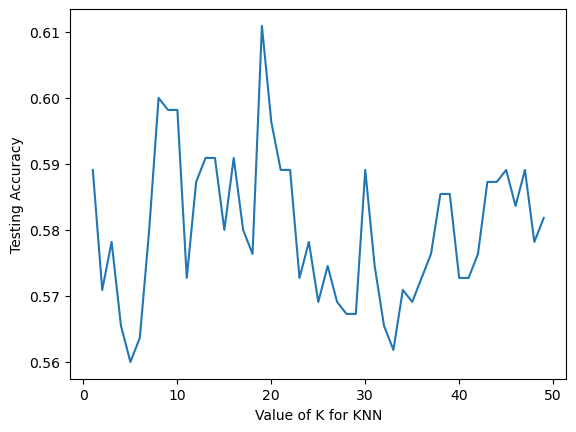

In [9]:
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

X, y = allData
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#random guessing
y_guess = np.random.randint(0, 2, len(y_test))
print('Random guessing accuracy: {}'.format(accuracy_score(y_test, y_guess)))

def run_experiment(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    return accuracy_score(y_test, y_pred)

k_range = range(1, 50)
k_scores = []
for k in k_range:
    classifier = BoW_Experiment(KNeighborsClassifier(n_neighbors=k))
    scores = run_experiment(classifier, X_train, y_train, X_test, y_test)
    k_scores.append(scores)

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')



Text(0, 0.5, 'Testing Accuracy')

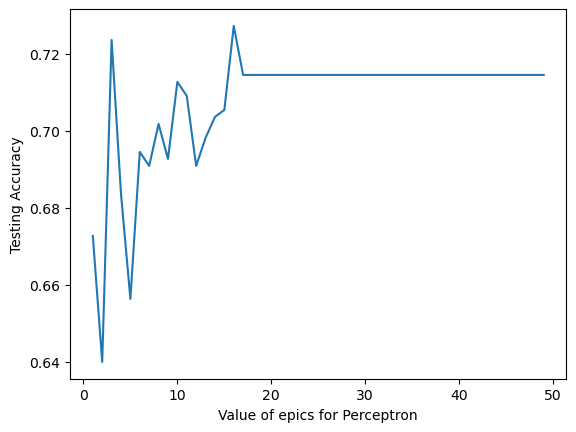

In [10]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

epic_range = range(1, 50)
epic_scores = []
for epic in epic_range:
    classifier = BoW_Experiment(Perceptron(max_iter=epic))
    scores = run_experiment(classifier, X_train, y_train, X_test, y_test)
    epic_scores.append(scores)

plt.plot(epic_range, epic_scores)
plt.xlabel('Value of epics for Perceptron')
plt.ylabel('Testing Accuracy')

Text(0, 0.5, 'Testing Accuracy')

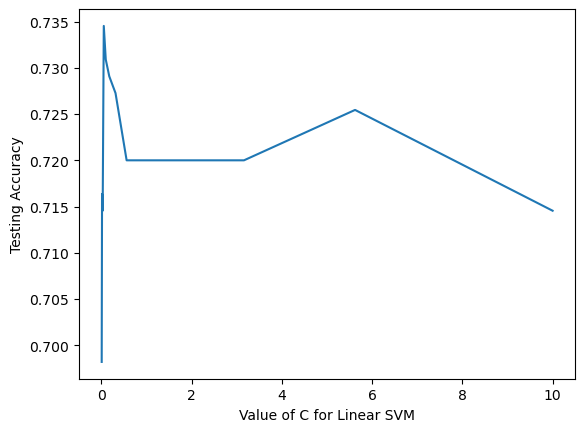

In [11]:
from sklearn.svm import LinearSVC
C_range = np.logspace(-2, 1, 13)
C_scores = []
for C in C_range:
    classifier = BoW_Experiment(LinearSVC(C=C))
    scores = run_experiment(classifier, X_train, y_train, X_test, y_test)
    C_scores.append(scores)

plt.plot(C_range, C_scores)
plt.xlabel('Value of C for Linear SVM')
plt.ylabel('Testing Accuracy')


Text(0, 0.5, 'Testing Accuracy')

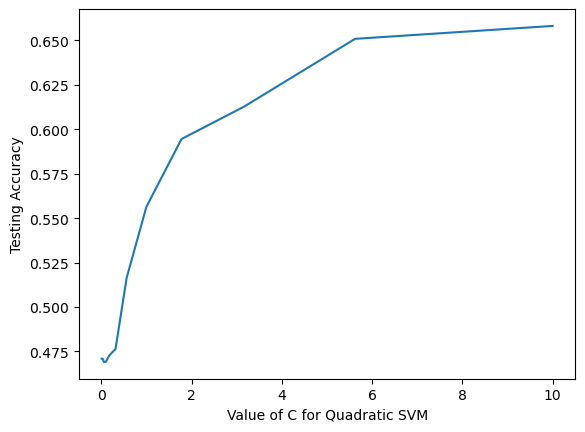

In [12]:
from sklearn.svm import SVC
C_range = np.logspace(-2, 1, 13)
C_scores = []
for C in C_range:
    classifier = BoW_Experiment(SVC(C=C, kernel='poly', degree=2))
    scores = run_experiment(classifier, X_train, y_train, X_test, y_test)
    C_scores.append(scores)

plt.plot(C_range, C_scores)
plt.xlabel('Value of C for Quadratic SVM')
plt.ylabel('Testing Accuracy')

Text(0, 0.5, 'Testing Accuracy')

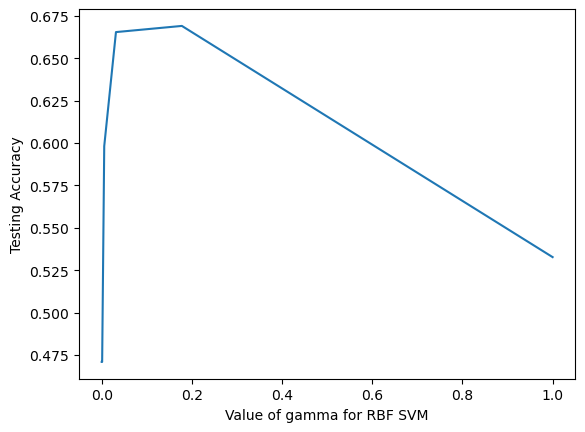

In [13]:
gamma_range = np.logspace(-9, 0, 13)
gamma_scores = []
for gamma in gamma_range:
    classifier = BoW_Experiment(SVC(gamma=gamma, kernel='rbf'))
    scores = run_experiment(classifier, X_train, y_train, X_test, y_test)
    gamma_scores.append(scores)

plt.plot(gamma_range, gamma_scores)
plt.xlabel('Value of gamma for RBF SVM')
plt.ylabel('Testing Accuracy')

From the above selection events, we will select our short list.
All of the classifiers except KNN outperformed random guessing.
Nearest Neighbors didn't seem to have any clear pattern to its response in accuracy to variation in the hyperparameter.
The linear approaches were the best performing, so the shortlist will be comprised of linear SVM and perceptron. 

Here are the hyperparameter's that we will fix for the remaining experiments.

* Perceptron : 20 epics
* Linear SVM : C = 1.5

## Standardization

Now that we have selected our experimental classifiers, we will seperate the data sets.
We can train the seperate classifiers for the sets and perform validation across sets. 

Standardization will be the easiest to incorporate into our tests, since we can activate it with a boolean in the `Bow_Experiment` wrapper. 
This is also the first step we would like to take in our future pipeline.
The `BoW_Experiment` wrapper will automatically standardize the data, save the element-wise scale and offset, and apply the transformation to any data to be predicted.

While the original design rested on using the `Bag` class to control the vectorization, this design trait will be ignored. 
This decision is due to the efficacy of `fog` for dimensional reduction.
The *blacklist* feature is also not necessary outside of most common.
The original plan was to compile a list of common neutral words like "the", "a", "is" and so on.
Finding a decent list of this sort that wouldn't have a bias proved difficult, so this feature will be unused as well.

Because of `fog` we only need the master `Lexicon` for all the files.

Although these flexibilities are not needed, we consider their inclusions in the software a success.

In [14]:
class PerceptronOfChoice(Perceptron):
    def __init__(self):
        super().__init__(max_iter=20, random_state=42)

class LinearSVMOfChoice(LinearSVC):
    def __init__(self):
        super().__init__(C=1.5, random_state = 42)  

classifiers = {
    'perceptron': PerceptronOfChoice,
    'linear_svm': LinearSVMOfChoice
}

In [15]:

from sklearn.svm import LinearSVC

global_bag = Bag(lexicons['all'], most_common_filter=20)
global_vectorizer = BoW_Vectorizer(global_bag)

vectorized_datasets = {
    'amazon': global_vectorizer.vectorize_data(sources['amazon']),
    'imdb': global_vectorizer.vectorize_data(sources['imdb']),
    'yelp': global_vectorizer.vectorize_data(sources['yelp']),
}


In [16]:
def run_experiment(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    return accuracy_score(y_test, y_pred)

def run_experiment_on_dataset(classifier, dataset):
    X, y = vectorized_datasets[dataset]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return run_experiment(classifier, X_train, y_train, X_test, y_test)

for dataset in vectorized_datasets:
    print('Dataset: {}'.format(dataset))
    for classifier in classifiers:
        print('Classifier: {}'.format(classifier))
        accuracy = run_experiment_on_dataset(BoW_Experiment(classifiers[classifier](), standard=True), dataset)
        print('Accuracy: {}'.format(accuracy))

Dataset: amazon
Classifier: perceptron
Accuracy: 0.61
Classifier: linear_svm
Accuracy: 0.69
Dataset: imdb
Classifier: perceptron
Accuracy: 0.5666666666666667
Classifier: linear_svm
Accuracy: 0.66
Dataset: yelp
Classifier: perceptron
Accuracy: 0.61
Classifier: linear_svm
Accuracy: 0.705


Here we see that the effect of standardization on this data, while negligible is, if anything, adverse to the accuracy of the classifiers. This result makes sense since all of the data is of the same type and generated in the same way. For this reason, we will leave the `standard=False` parameter in `BoW_Experiment` set for the remaining experiments.

## PCA

PCA analysis will be the next area of interest in our experiments. What is interesting about this particular data effect is that the principle components can be vectors that are not necessarily those that are defined with the bag of words. This is to say, it can reveal patterns about what combinations of words are important, versus the words themselves.

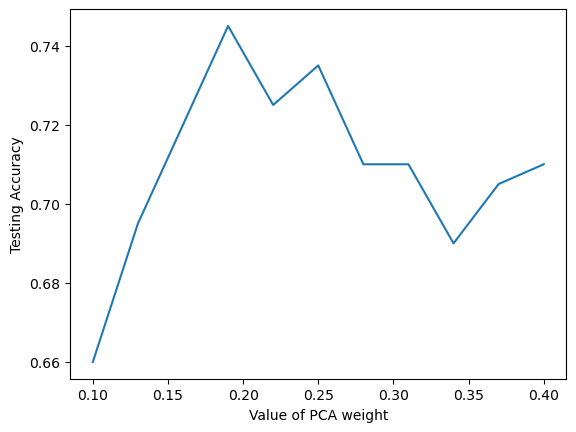

In [17]:
def find_optimal_pcaweight(classifier, dataset):
    X, y = vectorized_datasets[dataset]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    pca_range = np.linspace(0.1, .4, 11)
    pca_scores = []
    for pca_weight in pca_range:
        test_classifier = BoW_Experiment(classifiers[classifier](), pca_weight=pca_weight)
        scores = run_experiment(test_classifier, X_train, y_train, X_test, y_test)
        pca_scores.append(scores)
    plt.plot(pca_range, pca_scores)
    plt.xlabel('Value of PCA weight')
    plt.ylabel('Testing Accuracy')
    plt.show()

find_optimal_pcaweight('perceptron', 'amazon')

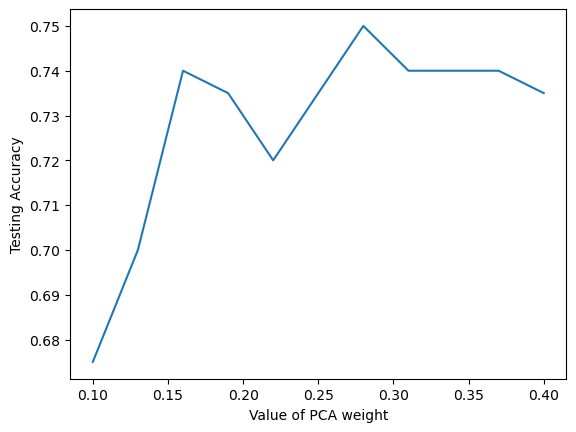

In [18]:
find_optimal_pcaweight('linear_svm', 'amazon')

The PCA appears to have a positive effect on the accuracy of our two linear models, although slight. It seems like large reduction in dimensionality has unpredictable, yet generally poor results. This outcome makes sense, if the principle components are based on words that are abundant in the training data, but do not appear as frequently in the test data. That is, for a small choice of principle components, we run the risk of focusing on features that may not be present in the test data set. 

It seems that a moderately generous proportion of principle components does well with both linear models.
Specifically, a range of `pca_weight` from .3 to .35 seems ideal.

Next we will attempt to extract some information about natural language from our model by observing which words pca groups together into components.
To do this we will have to account for the fact that the indices of PCA components are not the same as those of the vectorizer, due to the `fog` reduction.
To fix this, we will lookup the indices of the PCA components that will work with the vectorizer's reverse lookup feature.  

In [19]:
def extract_prefog_features(vector, fog_columns):
    return [(fog_columns[i], x) for i, x in enumerate(vector) if x != 0]

def foggy_vector_to_word_count(vector, fog_columns, bag):
    word_count = {}
    for word_index, count in extract_prefog_features(vector, fog_columns):
        word = bag[word_index]
        word_count[word] = count
    return word_count

def print_nth_pca_as_words(n, components, fog_columns, bag):
    print('PCA Component {}'.format(n))
    for word, count in sorted(foggy_vector_to_word_count(components[n], fog_columns, bag).items(), key=lambda x: x[1], reverse=True)[:10]:
        print('{}: {}'.format(word, count))

def print_pca_as_words(start, stop, classifier, dataset):
    X, y = vectorized_datasets[dataset]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    BoW = BoW_Experiment(classifiers[classifier](), pca_weight=0.32)
    BoW.fit(X_train, y_train)
    components = BoW.get_components()
    fog_columns = BoW.get_fog_columns()
    for i in range(start, stop):
        print_nth_pca_as_words(i, components, fog_columns, global_bag)
        print()


print_pca_as_words(1, 4, 'perceptron', 'amazon')



PCA Component 1
have: 0.7517046297218677
sound: 0.2977893169626509
had: 0.1736915702548723
quality: 0.17055916604413124
from: 0.080525322612878
any: 0.0766481991343467
don't: 0.06879997536883331
so: 0.06847763499749122
one: 0.06815749010053812
happy: 0.06423116787428777

PCA Component 2
as: 0.6875145006378953
are: 0.359246962825342
quality: 0.2186991287766155
good: 0.20001190864033933
well: 0.1538231271238812
sound: 0.15181992552318965
one: 0.11781508362315042
so: 0.1095710925440215
far: 0.09178037175454698
ease: 0.08107917567332336

PCA Component 3
are: 0.7144272743398283
great: 0.19562183139125844
sound: 0.1487856280310423
difficult: 0.1265777829653221
even: 0.09603391063418841
so: 0.08809001127315325
your: 0.08486891444404956
-: 0.07158311179385475
car: 0.06582539820450467
at: 0.06524619658365281



It is interesting to see the patterns that the PCA found in how it grouped together words.
With more robust preperation of the data, perhaps this could provide more enlightening insight into language.

## Inverse Document Frequency

Our final attempt at optimization will be weighting the vectors to discourage over emphasizing highly common words. As this feature is built into our `BoW_Experiment` we can simply compare our results

In [20]:
print("Perceptron on Amazon with IVD")
print(run_experiment_on_dataset(BoW_Experiment(PerceptronOfChoice(), IVD_weight=1), 'amazon'))
print("Perceptron on Amazon with IVD and PCA")
print(run_experiment_on_dataset(BoW_Experiment(PerceptronOfChoice(), IVD_weight=1, pca_weight=0.32), 'amazon'))

print("Linear SVM on Amazon with IVD")
print(run_experiment_on_dataset(BoW_Experiment(LinearSVMOfChoice(), IVD_weight=1), 'amazon'))
print("Linear SVM on Amazon with IVD and PCA")
print(run_experiment_on_dataset(BoW_Experiment(LinearSVMOfChoice(), IVD_weight=1, pca_weight=0.32), 'amazon'))


Perceptron on Amazon with IVD
0.665
Perceptron on Amazon with IVD and PCA
0.65
Linear SVM on Amazon with IVD
0.615
Linear SVM on Amazon with IVD and PCA
0.585


IVD seems to have an effect on our linear classifers that is mildly positive. In addition, the use of IVD with PCA seems to promise a slight improvement on IVD by itself.

## Inter-Source Validation

The final area of experimentation for this project will be using the different data sets from the various websites as validation for the effacacy of the model. Our experiments have shown that the best hyperparameters for the `BoW_Experiment` are simply PCA by itself, for both classifiers.
So, we will use this set up and measure the accuracy accross sets.

In [21]:
class BestBoW(BoW_Experiment):
    def __init__(self, type):
        if type == 'perceptron':
            super().__init__(PerceptronOfChoice(), pca_weight=0.32)
        elif type == 'linear_svm':
            super().__init__(LinearSVMOfChoice(), pca_weight=0.32)

def run_inter_source_experiment(classifier, source1, source2):
    print(classifier, 'trained on', source1, 'tested on', source2)
    X_train , y_train = vectorized_datasets[source1]
    X_test, y_test = vectorized_datasets[source2]
    return run_experiment(BestBoW(classifier), X_train, y_train, X_test, y_test)


print(run_inter_source_experiment('perceptron', 'amazon', 'imdb'))

print(run_inter_source_experiment('perceptron', 'yelp', 'amazon'))

print(run_inter_source_experiment('perceptron', 'yelp', 'imdb'))

print(run_inter_source_experiment('linear_svm', 'amazon', 'imdb'))

print(run_inter_source_experiment('linear_svm', 'yelp', 'amazon'))

print(run_inter_source_experiment('linear_svm', 'yelp', 'imdb'))


perceptron trained on amazon tested on imdb
0.6056149732620321
perceptron trained on yelp tested on amazon
0.608
perceptron trained on yelp tested on imdb
0.6256684491978609
linear_svm trained on amazon tested on imdb
0.6363636363636364
linear_svm trained on yelp tested on amazon
0.611
linear_svm trained on yelp tested on imdb
0.6243315508021391


From this experiment we can see that the performance of a model trained on one type of review does not generalize to the other types perfectly. 
We see a decrease in performance, but the model still performs better than a random classifier.

## Results

In this project we built a functional Bag of Words vectorization scheme to analyize natural language.
The initial finding favored linear classifiers by a significant degree.
It was shown that our best classifiers were a Perceptron and a Linear SVM with PCA dimensionality reduction by about 70%.
Inverse Document Frequency was anticipated to be a highly effective boost factor for the classifiers based on preliminary research into the topic.
While, IVD did provide an advantage of the unadulterated Bag of Words model, it was not nearly as potent as PCA.
PCA was so effective by comparison, that other methods typically reduced the increase in accuracy versus PCA by itself.

Below we will exposé the best classifer that was built.
Since, there is little difference between the Perceptron and the Linear SVM, we will simply use SVM.
We will train the perceptron on all of the data and use the vectorizer to predict the sentiment of some custom written reviews.

In [42]:
best_bow = BestBoW("linear_svm")
X, y = vectorized_datasets['amazon']
best_bow.setBag(global_bag)
best_bow.fit(X, y)

def try_a_sentence(sentence):
    print(sentence)
    #prediction = best_bow.predict(global_vectorizer.vectorize(sentence))
    prediction = best_bow.predict_text(sentence)
    if prediction == 1:
        print('Positive')
    else:
        print('Negative')

    print()



In [43]:
try_a_sentence("I love this movie")

try_a_sentence("I hate this movie")

try_a_sentence("I love how terrible this product is. It's the best at being a complete piece of garbage!")

try_a_sentence("Bought this toy for my daughter and she played with once and it broke. I would not recommend this toy to anyone.")

try_a_sentence("I hate how much I love this product! It is the worst at being a bad product.")

try_a_sentence("I was unsure about this product at first, but it turned out to be the best thing I've ever bought!")

I love this movie
Positive

I hate this movie
Negative

I love how terrible this product is. It's the best at being a complete piece of garbage!
Positive

Bought this toy for my daughter and she played with once and it broke. I would not recommend this toy to anyone.
Negative

I hate how much I love this product! It is the worst at being a bad product.
Negative

I was unsure about this product at first, but it turned out to be the best thing I've ever bought!
Negative



## Conclusion

This project was able to accomplish its goals of developing a Bag of Words model for sentiment analysis and comparing different versions of implementing a classifer with this method.
The resulting classifier leaves alot to be desired, but did demonstrate rudimentary performance.
Other methods could be employed to build on this process, in particular sanitizing the data more before vectorization.
A few canonical ways of doing this is to remove punctuation and to simplify words into their stems.

Further experiments could seek to improve this approach by implementing more advanced machine learning techniques such as ensembles and ridge regression.
Ultimately the Bag of Words approach is limited by its nature, since it ignores the affect of context in natural language.
State of the art NLP outshines these simplistic methods by very large margins.
